In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

In [6]:
bsd_train_path = '../../data/data_small/bike-sharing-demand/train.csv'
bsd_df = pd.read_csv(bsd_train_path, parse_dates=['datetime'])

# Ingeniería de características desde 'datetime'
bsd_df['datetime'] = pd.to_datetime(bsd_df['datetime'])
bsd_df['year'] = bsd_df['datetime'].dt.year
bsd_df['month'] = bsd_df['datetime'].dt.month
bsd_df['day'] = bsd_df['datetime'].dt.day
bsd_df['hour'] = bsd_df['datetime'].dt.hour
bsd_df['weekday'] = bsd_df['datetime'].dt.weekday
# bsd_df.drop('datetime', axis=1, inplace=True)

# Verificar dimensiones y columnas
print("Dimensiones del dataset:", bsd_df.shape)  # (10886, 17)

Dimensiones del dataset: (10886, 17)


**¿La demanda de bicicletas es mayor en días laborables que en fines de semana?**

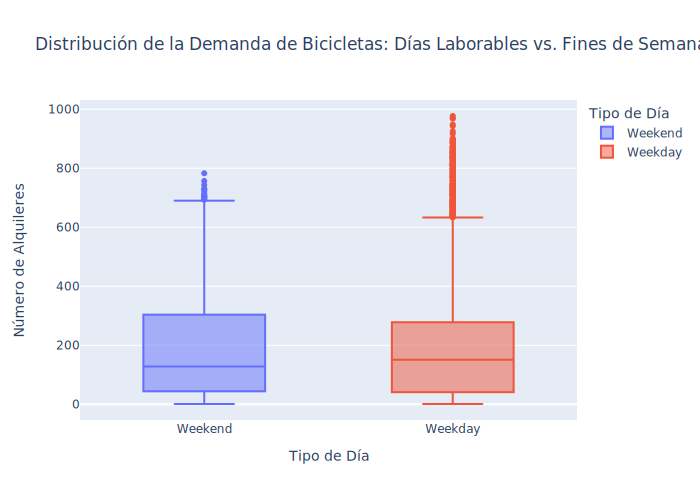

  day_type        mean  median         std
0  Weekday  192.724589   151.0  183.883687
1  Weekend  188.765096   128.0  174.271888


In [7]:
import pandas as pd
import plotly.express as px

# Cargar el dataset y preparar las columnas
bsd_df['day_type'] = bsd_df['weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Boxplot interactivo
fig = px.box(bsd_df, x='day_type', y='count', color='day_type',
             title='Distribución de la Demanda de Bicicletas: Días Laborables vs. Fines de Semana',
             labels={'day_type': 'Tipo de Día', 'count': 'Número de Alquileres'})
fig.show()

# Resumen numérico
summary = bsd_df.groupby('day_type')['count'].agg(['mean', 'median', 'std']).reset_index()
print(summary)

Dados los resultados de la gráfica es posible interpretar que no existe mucha diferencia entre la demanda de bicicletas en días laborales o festivos, por lo que es necesario realizar otros estudios para determinar la relación entre las variables.

**¿Existe una relación entre la temperatura y la demanda de bicicletas?**

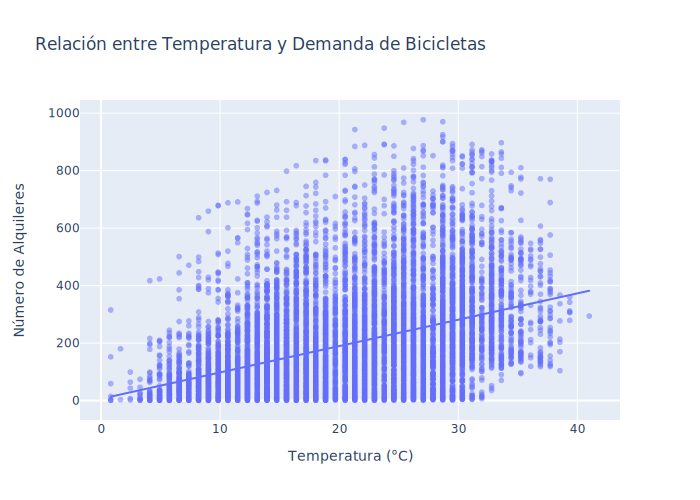

Coeficiente de correlación entre temperatura y demanda: 0.39


In [8]:
# Scatter plot con línea de tendencia
fig = px.scatter(bsd_df, x='temp', y='count', trendline='ols',
                 title='Relación entre Temperatura y Demanda de Bicicletas',
                 labels={'temp': 'Temperatura (°C)', 'count': 'Número de Alquileres'},
                 opacity=0.5)
fig.show()

# Coeficiente de correlación
correlation = bsd_df['temp'].corr(bsd_df['count'])
print(f"Coeficiente de correlación entre temperatura y demanda: {correlation:.2f}")

A partir de la información suministrada, se demuestra que existe una relación positiva entre la demanda de alquiler de bicicletas y la temperatura del ambiente, lo que quiere decir que a medida que aumenta la temperatura también incrementa el alquiler de biciletas. Desafortunadamente, el coeficiente es demasiado pequeño para afirmar que la temperatura es la única variable significativa dentro de la base de datos.

**¿Cómo varía la demanda de bicicletas según la hora del día en días laborables versus fines de semana?**

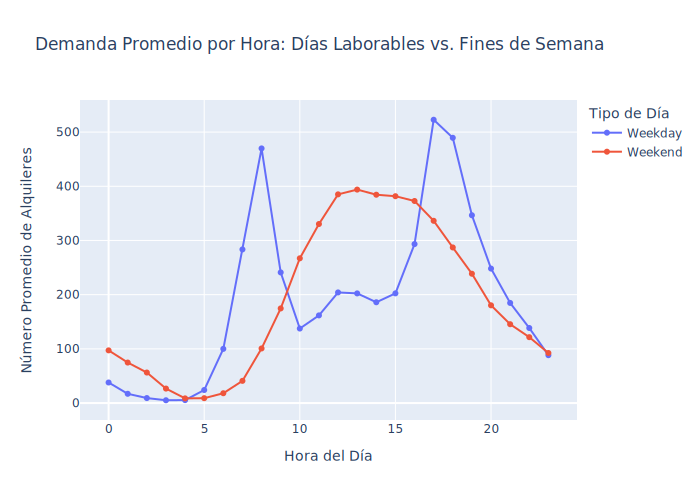

In [9]:
# Extraer hora y calcular demanda promedio
hourly_demand = bsd_df.groupby(['hour', 'day_type'])['count'].mean().reset_index()

# Gráfico de líneas interactivo
fig = px.line(hourly_demand, x='hour', y='count', color='day_type',
              title='Demanda Promedio por Hora: Días Laborables vs. Fines de Semana',
              labels={'hour': 'Hora del Día', 'count': 'Número Promedio de Alquileres', 'day_type': 'Tipo de Día'},
              markers=True)
fig.show()

# Resumen numérico
# print(hourly_demand.pivot(index='hour', columns='day_type', values='count'))

La curva que describe el comportamiento de la demanda de bicicletas varía significativamente dependiendo del día de la semana. Para los días entre semana, la mayor demanda de alquiler se da a las 8 de la mañana y 5 de la tarde, que es cuando las personas se trasladan a algún lugar de trabajo y a sus casas, respectivamente. Por el contrario, los fines de semana mayormente se alquilan bicicletas entre las 12 del medio día y las 4 de la tarde.

**¿Existe variación en la demanda teniendo en cuenta el tipo de día y el clima?**

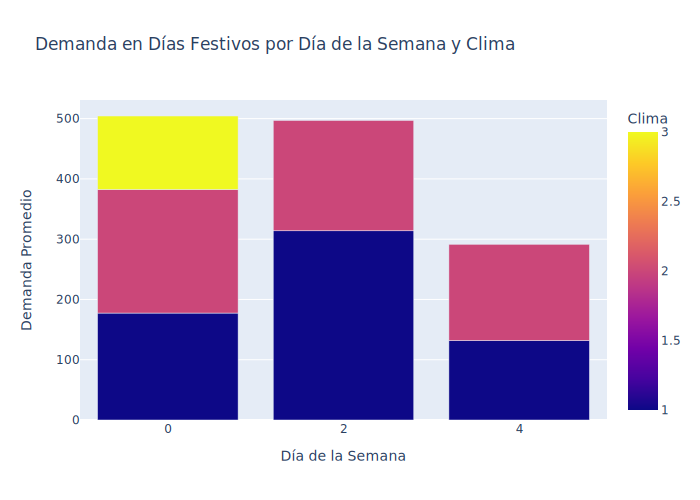

Estadísticas de demanda en días festivos:
   weekday  weather        mean         std
0        0        1  177.417266  172.680819
1        0        2  204.941176  172.509375
2        0        3  122.000000  122.477986
3        2        1  313.913043  204.940327
4        2        2  183.000000         NaN
5        4        1  131.809524   94.402418
6        4        2  159.666667  110.084816


In [10]:
# Filtrar días festivos y no festivos
df = bsd_df
holiday_data = df[df['holiday'] == 1]
non_holiday_data = df[df['holiday'] == 0]

# Gráfico para días festivos
fig_holiday = px.bar(holiday_data.groupby(['weekday', 'weather'])['count'].mean().reset_index(),
                     x='weekday', y='count', color='weather', barmode='group',
                     title='Demanda en Días Festivos por Día de la Semana y Clima',
                     labels={'weekday': 'Día de la Semana', 'count': 'Demanda Promedio', 'weather': 'Clima'})
fig_holiday.show()

# Resumen numérico: Promedio y desviación por combinaciones
summary_holiday = holiday_data.groupby(['weekday', 'weather'])['count'].agg(['mean', 'std']).reset_index()
print("Estadísticas de demanda en días festivos:")
print(summary_holiday)


En resumen, la gráfica sugiere que tanto el día de la semana como las condiciones climáticas son factores importantes que afectan la demanda de bicicletas en días festivos. Los planificadores urbanos y los operadores de servicios de bicicletas compartidas pueden utilizar esta información para optimizar la disponibilidad de bicicletas y mejorar la experiencia del usuario en días festivos.

**¿Existen "puntos de inflexión" en la temperatura o la velocidad del viento donde la demanda de bicicletas cambia drásticamente, y cómo se relacionan con la estacionalidad?**

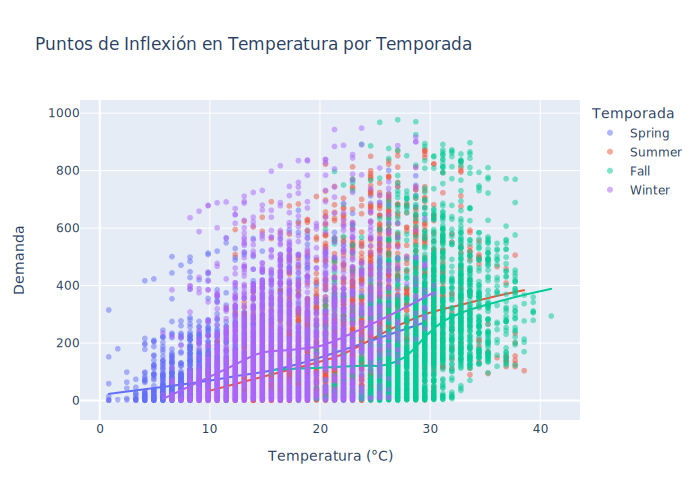

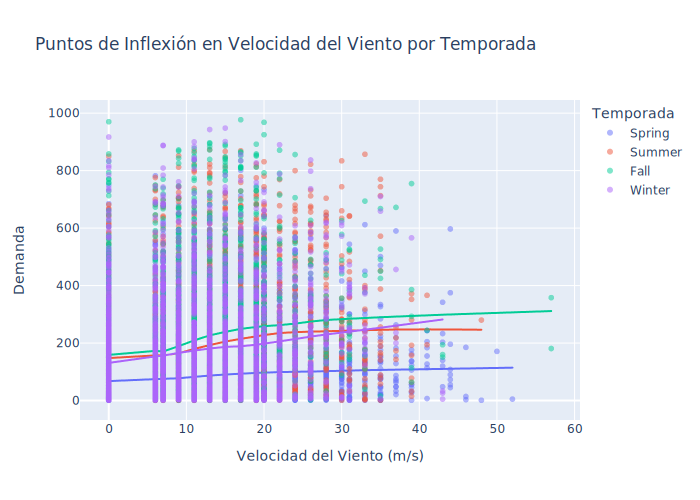

Spring: Temp. promedio en baja demanda: 10.4°C, Viento promedio: 12.8 m/s
Summer: Temp. promedio en baja demanda: 19.9°C, Viento promedio: 11.4 m/s
Fall: Temp. promedio en baja demanda: 26.4°C, Viento promedio: 9.1 m/s
Winter: Temp. promedio en baja demanda: 14.8°C, Viento promedio: 9.8 m/s


In [11]:
# Mapear temporadas
season_map = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
df['season_name'] = df['season'].map(season_map)

# Scatter con LOWESS para temperatura
fig_temp = px.scatter(df, x='temp', y='count', color='season_name', trendline='lowess',
                      title='Puntos de Inflexión en Temperatura por Temporada',
                      labels={'temp': 'Temperatura (°C)', 'count': 'Demanda', 'season_name': 'Temporada'},
                      opacity=0.5)
fig_temp.show()

# Scatter con LOWESS para velocidad del viento
fig_wind = px.scatter(df, x='windspeed', y='count', color='season_name', trendline='lowess',
                      title='Puntos de Inflexión en Velocidad del Viento por Temporada',
                      labels={'windspeed': 'Velocidad del Viento (m/s)', 'count': 'Demanda', 'season_name': 'Temporada'},
                      opacity=0.5)
fig_wind.show()

# Resumen numérico: Percentiles de cambio
for season in df['season_name'].unique():
    season_data = df[df['season_name'] == season]
    temp_drop = season_data[season_data['count'] < season_data['count'].quantile(0.25)]['temp'].mean()
    wind_drop = season_data[season_data['count'] < season_data['count'].quantile(0.25)]['windspeed'].mean()
    print(f"{season}: Temp. promedio en baja demanda: {temp_drop:.1f}°C, Viento promedio: {wind_drop:.1f} m/s")


Estos puntos de inflexión son cruciales para planificar la disponibilidad de bicicletas. Por ejemplo, durante el verano, se debe asegurar una mayor disponibilidad de bicicletas cuando las temperaturas están entre 20°C y 30°C.

